### 1. **Preparação dos Dados**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Carregamento do Dataset**

In [ ]:
# load dataset
train_data = pd.read_csv('/content/train_normalized.csv')
# Seleciona 1000 registros aleatoriamente
loaded_data = train_data.sample(n=900)

**Pré-processamento**

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Separa as features (X) e o target (y)
X = loaded_data.drop('loan_status', axis=1)
y = loaded_data['loan_status']

# Cria o objeto RandomUnderSampler
rus = RandomUnderSampler(random_state=42) # Define um random_state para reprodutibilidade

# Aplica o undersampling
X_resampled, y_resampled = rus.fit_resample(X, y)

# Verifica o balanceamento das classes
print(Counter(y_resampled))

# Cria um novo DataFrame com os dados balanceados
balanced_data = pd.DataFrame(X_resampled, columns=X.columns)
balanced_data['loan_status'] = y_resampled

Counter({0: 193, 1: 193})


In [ ]:
# extract features
X_train_data = balanced_data.loc[:, ["person_age", "person_income", "previous_loan_defaults_on_file"]]
train_data = balanced_data.loc[:, ["person_age", "person_income", "previous_loan_defaults_on_file", "loan_status"]]
train_data = train_data.rename(columns={'person_age': 'x1', 'person_income': 'x2', "previous_loan_defaults_on_file": 'x3'})

# split the data set into sampels(features) and labels
samples =  X_train_data.values.tolist()
labels  =  train_data['loan_status'].tolist()

### 2. **Construindo a rede LVQ1**

**Inicialização de Prototype Vectors**

Como estamos realizando uma classificação binária (1 ou 0), precisamos calcular apenas dois prototype vectors. Cada weight vector corresponderá a um dos possíveis valores de classe: um weight vector terá o valor 1, e o outro terá o valor 0.

In [ ]:
# initiate prototype vectors
# create an array for weights
weights = []
# append the first two sampels into it
# and remove them from the training samples
prototype1 = samples.pop(0)
weights.append(prototype1)
prototype2 = samples.pop(0)
weights.append(prototype2)
# remove thier labels from the training labels
labels.pop(0)
labels.pop(0)
# remove them from the data frame
train_data = train_data.iloc[2:]

**Exibição dos dados em 3D antes do treino**

Como cada amostra possui 3 características, iremos plotar os dados em 3D.

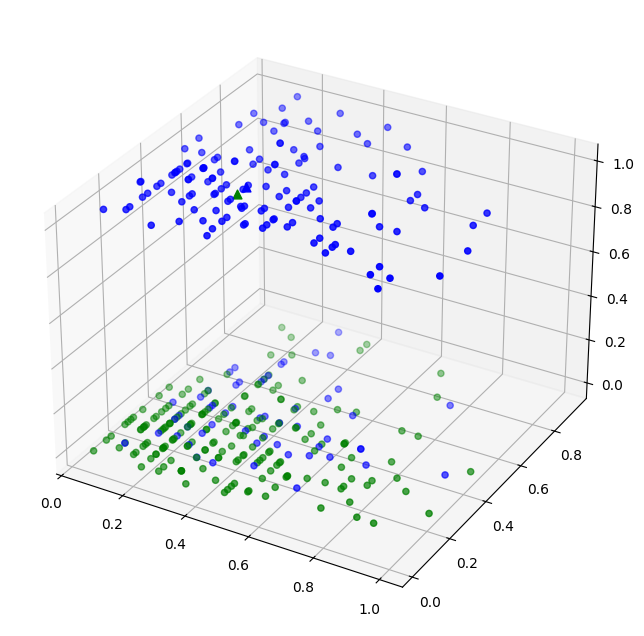

In [ ]:
# plot samples in 3D
# make a figure
fig=plt.figure(figsize=(8,8))
# make a 3D subplot
ax=fig.add_subplot(111,projection='3d')
# give each class a color
# class 1 ==> green
# class 0 ==> blue
c_colors = np.where(train_data['loan_status']==1,'g','b')
# plot the training samples as circles
ax.scatter(train_data['x1'],train_data['x2'],train_data['x3'],color=c_colors, )
# plot the 1st sample as a blue triangle
ax.scatter(weights[0][0], weights[0][1], weights[0][2], s=40, color='b', marker='^', label = 'class 0')
# plot the 1st sample as a green triangle
ax.scatter(weights[1][0], weights[1][1], weights[1][2], s=40, color='g', marker='^', label = 'class 1')

**LVQ1 Class**

In [ ]:
# LVQ1 model

class LVQ:

  def __init__(self, epochs, alpha):
    self.epochs = epochs
    self.alpha = alpha

  # define a function to find the winning vector
  # by calculating euclidean distance
  def winner(self, weights, sample):

    distance_0 = 0
    distance_1 = 0

    for i in range(len(sample)):
      # calculate euclidean distance between the given vector and the 1st prototype
      distance_0 = distance_0 + np.linalg.norm(sample[i] - weights[0][i])
      # calculate euclidean distance between the given vector and the 2nd prototype
      distance_1 = distance_1 + np.linalg.norm(sample[i] - weights[1][i])

    if distance_0 < distance_1:
        return 0
    else:
        return 1

  # define a function to update the winning prototype
  def update( self, weights, sample, l_sample, winner_class) :
    # if the label of the nearest prototype == the label of the given vector
    # then add alpha
    if l_sample == winner_class:
      for i in range(len(weights[0])) :
        weights[winner_class][i] = weights[winner_class][i] + self.alpha * (sample[i] - weights[winner_class][i])
    # if the label of the nearest prototype != the label of the given vector
    # then subtract alpha
    else:
      for i in range(len(weights[0])) :
        weights[winner_class][i] = weights[winner_class][i] - self.alpha * (sample[i] - weights[winner_class][i])

  # reduce learning rate
  def reduce_lr(self, step):
    self.alpha = self.alpha - (step * 0.000001)

### 4. **Treinamento Final e Avaliação**

Inicialmente, instanciamos um objeto chamado LVQ1 com os parâmetros de 20 épocas e alpha de 0.5 a partir da classe LVQ. Em seguida, utilizando um loop `for` que percorre as amostras, obtivemos a classe mais próxima para cada amostra e recuperamos seu rótulo atual da lista de rótulos. Depois, atualizamos os pesos usando a função de atualização e repetimos esse processo para todas as amostras. Por fim, reduzimos o valor de alpha.

In [ ]:
# train LVQ1 network

# create an object from LVQ class
LVQ1 = LVQ(20, 0.05)

# repeate for all the epoches
for i in range(LVQ1.epochs):
  # for each sample
  for j in range(len(samples)):
    # take the sample
    sample = samples[j]
    # find the nearest class
    winner_class = LVQ1.winner(weights, sample)
    # take the label of the given sample
    l_sample = labels[j]
    # update prototypes (weights)
    LVQ1.update(weights, sample, l_sample, winner_class)
  # reduce learning rate
  LVQ1.reduce_lr(i)

**Exibição dos dados em 3D depois do treinamento**

Após concluir 20 épocas de treinamento, esperamos que os valores dos pesos dos dois vetores protótipos tenham sido modificados. Assim, podemos visualizar os dados e inspecionar o resultado.

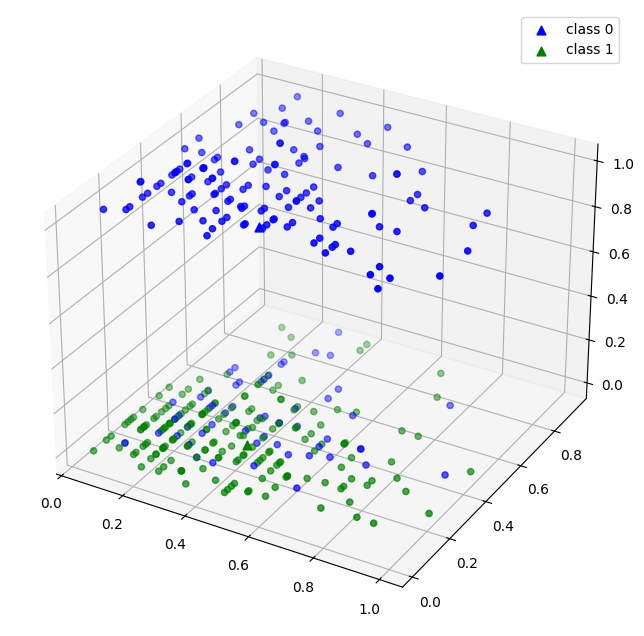

In [ ]:
# plot samples after training
# make a figure
fig=plt.figure(figsize=(8,8))
# make a 3D subplot
ax=fig.add_subplot(111,projection='3d')
# give each class a color
# class 1 ==> green
# class 0 ==> blue
c_colors = np.where(train_data['loan_status']==1,'g','b')
# plot the training samples as circles
ax.scatter(train_data['x1'],train_data['x2'],train_data['x3'],color=c_colors, )
# plot the 1st sample as a blue triangle
ax.scatter(weights[0][0], weights[0][1], weights[0][2], s=40, color='b', marker='^', label = 'class 0')
# plot the 1st sample as a green triangle
ax.scatter(weights[1][0], weights[1][1], weights[1][2], s=40, color='g', marker='^', label = 'class 1')
ax.legend(loc="best")

In [ ]:
test_data = pd.read_csv('/content/test_normalized.csv')
test_sample = test_data.loc[:, ["person_age", "person_income", "previous_loan_defaults_on_file", "loan_status"]]
test_sample.head()

,person_age,person_income,previous_loan_defaults_on_file,loan_status
0,0.263158,0.479126,0,0
1,0.210526,0.493486,1,0
2,0.105263,0.387033,1,0
3,0.368421,0.391256,1,0
4,0.315789,0.391256,0,1


In [ ]:
# test The network with the given sample
# the test sample
test_sample = np.array([[0.210526, 0.493486, 1]])
# convert it into list
sample = test_sample[0].T.tolist()
# make prediction, find the corresponding class
w_class = LVQ1.winner(weights, sample )

print("The given sample belongs to class : ", w_class)

The given sample belongs to class :  0


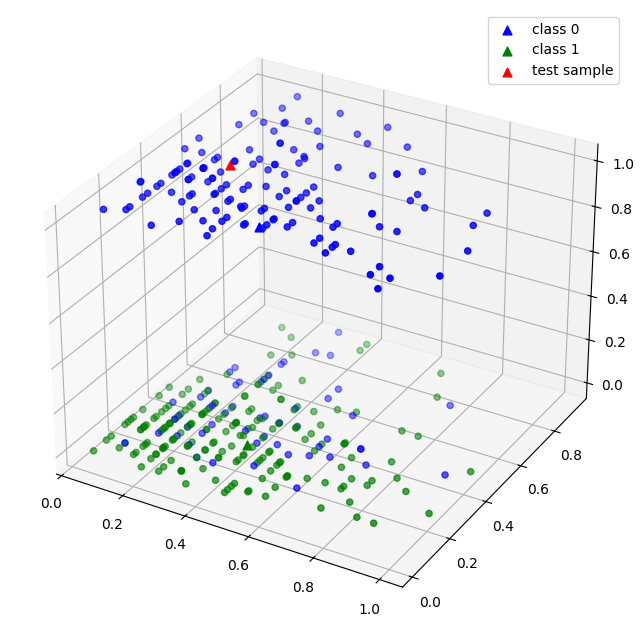

In [ ]:
# see the test sample on the 3D plot
# make a figure
fig=plt.figure(figsize=(8,8))
# make a 3D subplot
ax=fig.add_subplot(111,projection='3d')
# give each class a color
# class 1 ==> green
# class 0 ==> blue
c_colors = np.where(train_data['loan_status']==1,'g','b')
# plot the training samples as circles
ax.scatter(train_data['x1'],train_data['x2'],train_data['x3'],color=c_colors, )
# plot the 1st sample as a blue triangle
ax.scatter(weights[0][0], weights[0][1], weights[0][2], s=40, color='b', marker='^', label = 'class 0')
# plot the 1st sample as a green triangle
ax.scatter(weights[1][0], weights[1][1], weights[1][2], s=40, color='g', marker='^', label = 'class 1')
# plot the test sample as a red triangle
ax.scatter(test_sample[0][0], test_sample[0][1], test_sample[0][2], s=40, color='r', marker='^', label = 'test sample')
ax.legend(loc="best")